<a href="https://colab.research.google.com/github/FinnRobertson15/PatternAnalysis-2023/blob/topic-recognition/Colab%20version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
%cd

/root


In [3]:
import zipfile
import os

# Define the paths
zip_path = '/content/drive/MyDrive/AD_NC.zip'  # Path to the zip file
extract_path = '/content/extracted_folder'  # Path where you want to extract the contents

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the contents of the extracted folder
extracted_files = os.listdir(extract_path)
print(extracted_files)

['AD_NC']


In [4]:
cd /content/extracted_folder/AD_NC

/content/extracted_folder/AD_NC


In [5]:
ls

test/  train/


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import time
import numpy as np
# import pandas as pd
import math
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import shuffle
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset
import random

In [ ]:
batch_size = 128

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

class SiameseDataset(Dataset):
    def __init__(self, AD, NC):
        # Combine the datasets and labels
        self.X = AD + NC

        self.Y = torch.cat((torch.ones(len(AD)), torch.zeros(len(NC))), dim=0)

        # Generate a random permutation of indices
        self.i_indices = torch.randperm(len(self.X) // 2)
        self.j_indices = torch.randperm(len(self.X) // 2)


    def __len__(self):
        return len(self.X) // 2

    def __getitem__(self, idx):
        i = self.i_indices[idx] * 2
        j = self.j_indices[idx] * 2 + 1
        img1 = self.X[i]
        img2 = self.X[j]
        l1 = self.Y[i]
        l2 = self.Y[j]

        return img1, img2, l1, l2

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


size = 64

def intensity_normalization(img):
    mean = torch.mean(img)
    std = torch.std(img)
    return (img - mean) / std

def windowing(img, window_center, window_width):
    img = torch.clamp(img, window_center - window_width // 2, window_center + window_width // 2)
    img = (img - (window_center - 0.5)) / (window_width - 1)
    return img

# Example usage in your transform
transform_X = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Lambda(intensity_normalization),
    transforms.Lambda(lambda x: windowing(x, window_center=size // 2, window_width=size))
])


# Replace 'your_nii_folder' with the path to your folder containing .nii files
# nii_dataset = NiiDataset(root_dir=r'keras_png_slices_data\keras_png_slices_data\keras_png_slices_train')
loaders = {}

for stage in ['test']:
    loaders[stage] = {}
    AD = CustomDataset(root_dir=os.path.join(stage, 'AD'), transform=transform_X)
    NC = CustomDataset(root_dir=os.path.join(stage, 'NC'), transform=transform_X)
    dataset = SiameseDataset(AD, NC)
    loaders[stage] = DataLoader(dataset, batch_size=batch_size)

In [ ]:
count = 0
same = 0
for i, j, n, m in loaders['test']:
  count += len(n)
  same += (n == m).sum().tolist()
same / count

0.5144444444444445

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class SiameseNetwork(nn.Module):
    def __init__(self, pretrained=True):
        super(SiameseNetwork, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        # Modify the first convolution layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc1 = nn.Linear(1000, 500)  # Customize the fully connected layers
        self.fc2 = nn.Linear(500, 2)  # Customize the fully connected layers

    def forward(self, x1, x2):
        output1 = self.resnet(x1)
        output2 = self.resnet(x2)
        output = torch.abs(output1 - output2)
        output = self.fc1(output)
        output = self.fc2(output)
        return output

model = SiameseNetwork()

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [ ]:
# Initialize the network, loss function, and optimizer
siamese_net = SiameseNetwork(pretrained=True).to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(siamese_net.parameters(), lr=0.001)
# Training loop
epochs = 5
total_step = len(loaders['test'])
for epoch in range(epochs):
  for i, (img1, img2, lab1, lab2) in enumerate(loaders['test']):
    img1, img2, lab1, lab2 = img1.to(device), img2.to(device), lab1.to(device), lab2.to(device)
    output = siamese_net(img1, img2)
    o1, o2 = output[:, 0], output[:, 1]
    label = (lab1 == lab2).int()

    loss = criterion(o1, o2, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) % 21 == 0:
      print((lab1[0], lab2[0]))
      print(label[0])
      print(output[0])
      print(f"Epoch [{epoch + 1} / {epochs}], Step [{i + 1} / {total_step} Loss {loss.item()}]")

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))
tensor(0, device='cuda:0', dtype=torch.int32)
tensor([ 0.0997, -0.0306], device='cuda:0', grad_fn=<SelectBackward0>)
Epoch [1 / 5], Step [21 / 141 Loss 0.9753031730651855]
(tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))
tensor(1, device='cuda:0', dtype=torch.int32)
tensor([ 0.1081, -0.0379], device='cuda:0', grad_fn=<SelectBackward0>)
Epoch [1 / 5], Step [42 / 141 Loss 1.025275707244873]
(tensor(1., device='cuda:0'), tensor(0., device='cuda:0'))
tensor(0, device='cuda:0', dtype=torch.int32)
tensor([ 0.0929, -0.0268], device='cuda:0', grad_fn=<SelectBackward0>)
Epoch [1 / 5], Step [63 / 141 Loss 0.9390543699264526]
(tensor(1., device='cuda:0'), tensor(0., device='cuda:0'))
tensor(0, device='cuda:0', dtype=torch.int32)
tensor([ 0.1265, -0.0541], device='cuda:0', grad_fn=<SelectBackward0>)
Epoch [1 / 5], Step [84 / 141 Loss 1.0038050413131714]
(tensor(1., device='cuda:0'), tensor(0., device='cuda:0'))
tensor(0, device='

In [ ]:
correct = 0
total = 0
features = []
labels = []
with torch.no_grad():
    for i, (img1, img2, lab1, lab2) in enumerate(loaders['test']):
        img1, img2, lab1, lab2 = img1.to(device), img2.to(device), lab1.to(device), lab2.to(device)
        output = siamese_net(img1, img2)
        out1, out2 = output[:, 0], output[:, 1]
        predicted = (out1 - out2).pow(2).sum().sqrt().lt(0.5)
        total += lab1.size(0)
        correct += (predicted == lab1).sum().item()
        features.extend(out1.tolist())
        labels.extend(lab1.tolist())
        features.extend(out2.tolist())
        labels.extend(lab2.tolist())


    print(f'Accuracy of the network on the test images: {100 * correct / total}%')


Accuracy of the network on the test images: 49.955555555555556%


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.array(features).reshape(-1, 1), labels, test_size=0.2, random_state=42)

# Train a logistic regression model
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.49166666666666664


In [ ]:
features[0].tolist()

0.5943959355354309

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 80

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

class TripletDataset(Dataset):
    def __init__(self, AD, NC, transform=None):
        self.X = AD + NC
        self.AD = AD
        self.NC = NC
        self.Y = torch.cat((torch.ones(len(AD)), torch.zeros(len(NC))), dim=0)
        self.anc_indices = torch.randperm(len(self.X))
        self.pos_indices = torch.randperm(len(self.X)) % len(AD)
        self.neg_indices = torch.randperm(len(self.X)) % len(NC)
        self.transform = transform

    def __len__(self):
        return len(self.anc_indices)

    def __getitem__(self, idx):
        anc = self.anc_indices[idx]
        pos = self.pos_indices[idx]
        neg = self.neg_indices[idx]
        img1 = self.X[anc]
        img2 = self.AD[pos]
        img3 = self.NC[neg]
        label = self.Y[anc]

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            img3 = self.transform(img3)

        return img1, img2, img3, label



# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


size = 256

def intensity_normalization(img, mean = None, std = None):
    mean = torch.mean(img)
    std = torch.std(img)
    return (img - mean) / std

class CustomNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        return (img - self.mean) / self.std

transform_train = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=5),  # Randomly rotate the image by up to 5 degrees
    # transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),  # Adjust color jitter with smaller increments
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Random affine transformations with smaller parameters
    transforms.Lambda(intensity_normalization)

])

transform_test = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Lambda(intensity_normalization)
])

class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        return (img - self.mean) / self.std



# Replace 'your_nii_folder' with the path to your folder containing .nii files
# nii_dataset = NiiDataset(root_dir=r'keras_png_slices_data\keras_png_slices_data\keras_png_slices_train')
loaders = {}

for stage in ['train', 'test']:
    if stage == 'train':
      transform = transform_train
    else:
      transform = transform_test
    AD = CustomDataset(root_dir=os.path.join(stage, 'AD'), transform=transform)
    NC = CustomDataset(root_dir=os.path.join(stage, 'NC'), transform=transform)
    if stage == 'train':
      X = torch.stack([img for img in AD + NC])
      # Compute the mean and standard deviation
      mean = X.mean()
      std = X.std()
    normalize = transforms.Compose([
        Normalize(mean, std)
    ])
    dataset = TripletDataset(AD, NC)
    loaders[stage] = DataLoader(dataset, batch_size=batch_size)

In [47]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class TripletSiameseNetwork(nn.Module):
    def __init__(self, pretrained=True):
        super(TripletSiameseNetwork, self).__init__()
        self.resnet = models.resnet18(pretrained=pretrained)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.fc1 = nn.Linear(1000, 500)
        self.fc2 = nn.Linear(500, 2)

    def forward_once(self, x):
        output = self.resnet(x)
        output = self.fc1(output)
        output = self.fc2(output)
        return output

    def forward(self, anchor, positive, negative):
        output_anchor = self.forward_once(anchor)
        output_positive = self.forward_once(positive)
        output_negative = self.forward_once(negative)
        return output_anchor, output_positive, output_negative

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

class TripletLossWithRegularization(nn.Module):
    def __init__(self, margin=1.0, lambda_reg=0.01):
        super(TripletLossWithRegularization, self).__init__()
        self.margin = margin
        self.lambda_reg = lambda_reg  # Regularization parameter

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        triplet_losses = F.relu(distance_positive - distance_negative + self.margin)
        triplet_loss = triplet_losses.mean()

        # Compute L2 regularization
        l2_reg = None
        for param in trip_model.parameters():
            if l2_reg is None:
                l2_reg = param.norm(2)
            else:
                l2_reg = l2_reg + param.norm(2)

        loss = triplet_loss + self.lambda_reg * l2_reg
        return loss





In [48]:
from torch.optim.lr_scheduler import StepLR
learning_rate = 0.001
trip_model = TripletSiameseNetwork()
trip_criterion = TripletLossWithRegularization(margin=1.0)
total_step = len(loaders['train'])

optimizer = optim.Adam(trip_model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=15, gamma=0.75)

In [ ]:
from itertools import cycle

test_iter = cycle(iter(loaders['test']))
# Training loop
epochs = 100
trip_model.to(device)
losses = []
val_losses = []
for epoch in range(epochs):
  losses.append([])
  val_losses.append([])
  for i, (img1, img2, img3, _) in enumerate(loaders['train']):
    img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
    size = img1.size(0)
    img1, img2, img3 = img1[torch.randperm(size)], img2[torch.randperm(size)], img3[torch.randperm(size)]
    out1, out2, out3 = trip_model(img1, img2, img3)

    loss = trip_criterion(out1, out2, out3)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) % (total_step // 10) == 0:
      losses[epoch].append(loss.item())

      val_img1, val_img2, val_img3, _ = next(test_iter)
      val_img1, val_img2, val_img3 = val_img1.to(device), val_img2.to(device), val_img3.to(device)
      val_out1, val_out2, val_out3 = trip_model(val_img1, val_img2, val_img3)
      val_loss = trip_criterion(val_out1, val_out2, val_out3)
      val_losses[epoch].append(val_loss.item())

      print(f"Epoch [{epoch + 1} / {epochs}], Step [{i + 1} / {total_step}], Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

    scheduler.step()

Epoch [1 / 100], Step [26 / 269], Loss: 6.237911701202393, Validation Loss: 6.3210039138793945
Epoch [1 / 100], Step [52 / 269], Loss: 6.128037929534912, Validation Loss: 6.244564056396484
Epoch [1 / 100], Step [78 / 269], Loss: 6.11774206161499, Validation Loss: 6.238094806671143
Epoch [1 / 100], Step [104 / 269], Loss: 6.161336898803711, Validation Loss: 6.252033233642578


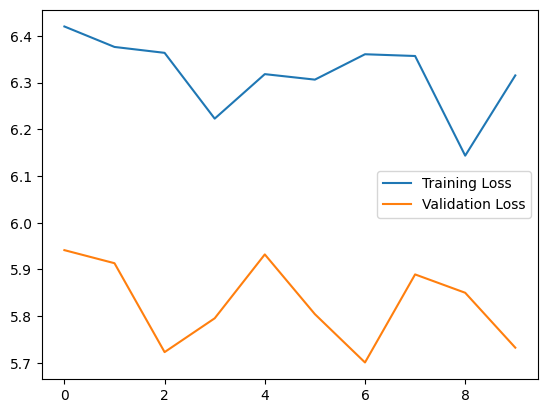

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation



fig, ax = plt.subplots()
line1, = ax.plot(np.arange(len(losses[0])), losses[0], label='Training Loss')
line2, = ax.plot(np.arange(len(val_losses[0])), val_losses[0], label='Validation Loss')
ax.legend()



def update(frame):
    line1.set_data(np.arange(len(losses[frame])), losses[frame])
    line2.set_data(np.arange(len(val_losses[frame])), val_losses[frame])
    return line1, line2

ani = FuncAnimation(fig, update, frames=len(losses), blit=True)
plt.show()


In [ ]:
embeddings = []
labels = []
trip_model.eval()
with torch.no_grad():
    for i, (img1, img2, img3, label) in enumerate(loaders['test']):
        img1, img2, img3, label = img1.to(device), img2.to(device), img3.to(device), label.to(device)
        out1, _, _ = trip_model(img1, img2, img3)
        embeddings.extend(out1.cpu().tolist())
        labels.extend(label.cpu().tolist())


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

# Train a logistic regression model
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.58
